# ch 11_2 streamlit을 이용한 머신러닝 모델 서빙

이번 챕터에서는 streamlit을 이용하여 미리 학습시킨 ML 모델을 서빙하는 서비스를 개발해보겠습니다. 이를 위해서 타이타닉 생존자 데이터 셋을 가지고, 생존율을 예측하는 RandomForestRegressor 모델을 학습시켜 보겠습니다. 모델을 서빙하는 서비스 개발이 목적이니, 모델 학습과 관련된 세부 내용은 생략하겠습니다.

## RandomForesRegressor 모델 학습

decision tree 챕터에서 배웠던 모델은 탑승자의 정보를 통대로 생존 여부를 0과 1로 분류하는 classification 모델을 배웠습니다. 이번에는 생존 확률을 0과 1 사이의 값으로 예측하는 regression 모델을 학습시켜보겠습니다. 기본적인 원리는 동일하고, 최종 예측 값이 0과 1 사이 연속적인 값으로 나온다는 것만 기억하면 됩니다.

In [1]:
import pandas as pd

In [12]:
train_df = pd.read_csv("./data/titanic_train.csv")
test_df = pd.read_csv("./data/titanic_test.csv")

In [13]:
train_df = train_df[["Survived", "Pclass", "Age", "Sex"]]
test_df = test_df[["Pclass", "Age", "Sex"]]

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_df["Sex"])

def preprocess(df):
    df["Age"] = df["Age"].fillna(0)
    df["Sex"] = label_encoder.transform(df["Sex"])
    return df

In [15]:
train_df = preprocess(train_df)
test_df = preprocess(test_df)

In [18]:
x_train = train_df.drop(["Survived"], axis=1)
y_train = train_df["Survived"]
x_test = test_df

In [19]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=1234
)
model.fit(x_train.values, y_train.values)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=50, random_state=1234)

In [28]:
pclass = 3
age = 20
sex = 0
model.predict([[pclass, age, sex]])[0]

0.2678107722171189

## 생존율 분포 시각화를 위해 inference 진행

유저에게 예상 생존율만 알려주면 너무 휑하니, 전체 생존율 분포 가운데 어디에 위치해 있는지를 알려주는 플랏을 한번 그려보겠습니다. 이를 위해 먼저, 전체 탑승객들의 데이터를 가지고 생존율을 예측해보겠습니다.

In [29]:
scores = model.predict(pd.concat([x_train, x_test]))

/Users/user/miniconda3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [30]:
scores

array([0.08080264, 0.89338095, 0.67469015, ..., 0.00196721, 0.09565066,
       0.09565066])

### 생존율 분포 시각화

seaborn을 이용하여 전체 생존률 분포에서 어디에 위치하는 지를 보여주기 위한 plot을 그립니다. 생존율이 0.5라고 가정하고 그려보겠습니다.

([<matplotlib.axis.XTick at 0x29eb2c070>,
 [Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0, 0, '1.0')])

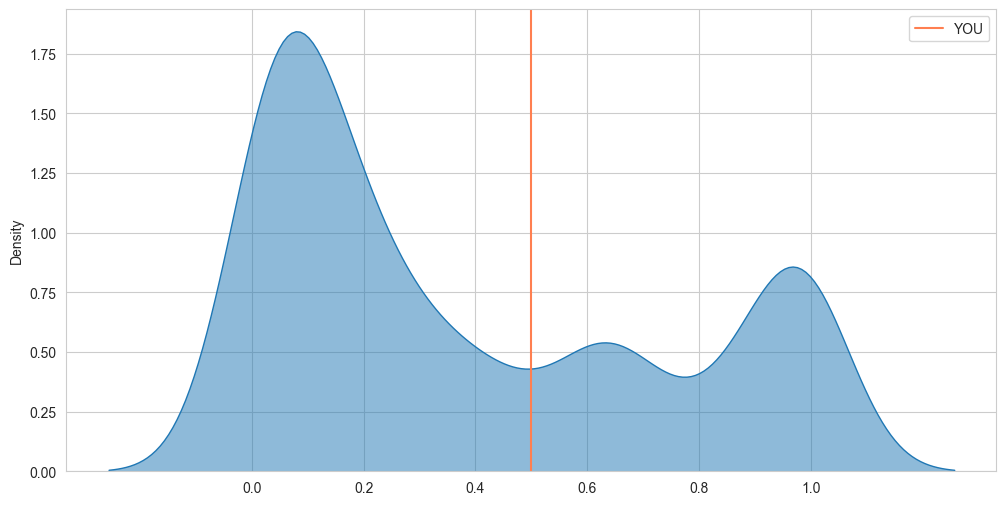

In [41]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
sns.set_style("whitegrid")
sns.kdeplot(
    scores,
    fill=True,
    alpha=0.5,
    ax=ax,
)
plt.axvline(0.5, color="coral", label="YOU")
plt.legend()
plt.xticks(np.arange(0, 1.2, 0.2))

### scores 저장

점수 분포대 plot을 그리기 위해서는 scores 데이터가 필요합니다. csv 파일 형태로 저장합니다.

In [42]:
import csv

with open("./data/scores.csv", "w") as fw:
    writer = csv.writer(fw)
    for score in scores:
        writer.writerow([score])

## 모델 저장

학습시킨 RandomForestRegressor 모델은 pickle을 이용해서 저장합니다.

In [43]:
import pickle

with open("./data/model.pkl", "wb") as fw:
    pickle.dump(model, fw)

잘 저장되었는지, 한번 읽어와서 인퍼런스를 해보겠습니다.

In [44]:
with open("./data/model.pkl", "rb") as fr:
    model = pickle.load(fr)

In [45]:
model.predict([[2, 10, 1]])

array([0.59838095])

## 정리

이번 챕터에서는 타이타닉호 생존율 예측 서비스를 개발하기 위해 필요한 생존율 예측 모델을 학습시켜보았습니다. RandomForestRegressor를 학습시켜봤고, 이전에 배웠던 classification 모델과 크게 다르지 않았습니다. 또한 단순히 예상 생존율 뿐만 아니라 분포 상에 어디에 위치해 있는지도 시각화 해보았습니다. 이를 바탕으로 streamlit을 사용하여 서비스 개발을 해보겠습니다.